# Tracking an unknown number of objects

While SVI can be used to learn components and assignments of a mixture model, pyro.contrib.tracking provides more efficient inference algorithms to estimate assignments. This notebook demonstrates how to use the `MarginalAssignmentPersistent` inside SVI.

In [1]:
from __future__ import absolute_import, division, print_function
import math
import os
import torch
from torch.distributions import constraints
from matplotlib import pyplot

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.tracking.assignment import MarginalAssignmentPersistent
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam

%matplotlib inline
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)

Let's consider a model with deterministic dynamics, say sinusoids with known period but unknown phase and amplitude.

In [2]:
def get_dynamics(num_frames):
    time = torch.arange(num_frames) / 4
    return torch.stack([time.cos(), time.sin()], -1)

It's tricky to define a fully generative model, so instead we'll separate our data generation process `generate_data()` from a factor graph `model()` that will be used in inference.

In [3]:
def generate_data(args):
    # Object model.
    num_objects = int(round(args.expected_num_objects))  # Deterministic.
    states = dist.Normal(0., 1.).sample((num_objects, 2))

    # Detection model.
    emitted = dist.Bernoulli(args.emission_prob).sample((args.num_frames, num_objects))
    num_spurious = dist.Poisson(args.expected_num_spurious).sample((args.num_frames,))
    max_num_detections = int((num_spurious + emitted.sum(-1)).max())
    observations = torch.zeros(args.num_frames, max_num_detections, 1+1) # position+confidence
    positions = get_dynamics(args.num_frames).mm(states.t())
    noisy_positions = dist.Normal(positions, args.emission_noise_scale).sample()
    for t in range(args.num_frames):
        j = 0
        for i, e in enumerate(emitted[t]):
            if e:
                observations[t, j, 0] = noisy_positions[t, i]
                observations[t, j, 1] = 1
                j += 1
        n = int(num_spurious[t])
        if n:
            observations[t, j:j+n, 0] = dist.Normal(0., 1.).sample((n,))
            observations[t, j:j+n, 1] = 1

    return states, positions, observations

In [4]:
@poutine.broadcast
def model(args, observations):
    with pyro.iarange("objects", args.max_num_objects):
        exists = pyro.sample("exists",
                             dist.Bernoulli(args.expected_num_objects / args.max_num_objects))
        with poutine.scale(scale=exists):
            states = pyro.sample("states", dist.Normal(0., 1.).expand([2]).independent(1))
            positions = get_dynamics(args.num_frames).mm(states.t())
    with pyro.iarange("detections", observations.shape[1]):
        with pyro.iarange("time", args.num_frames):
            # The combinatorial part of the log prob is approximated to allow independence.
            is_observed = (observations[..., -1] > 0)
            with poutine.scale(scale=is_observed.float()):
                assign = pyro.sample("assign",
                                     dist.Categorical(torch.ones(args.max_num_objects + 1)))
            is_spurious = (assign == args.max_num_objects)
            is_real = is_observed & ~is_spurious
            num_observed = is_observed.float().sum(-1, True)
            pyro.sample("is_real",
                        dist.Bernoulli(args.expected_num_objects / num_observed),
                        obs=is_real.float())
            pyro.sample("is_spurious",
                        dist.Bernoulli(args.expected_num_spurious / num_observed),
                        obs=is_spurious.float())

            # The remaining continuous part is exact.
            observed_positions = observations[..., 0]
            with poutine.scale(scale=is_real.float()):
                bogus_position = positions.new_zeros(args.num_frames, 1)
                augmented_positions = torch.cat([positions, bogus_position], -1)
                predicted_positions = augmented_positions[:, assign]
                pyro.sample("real_observations",
                            dist.Normal(predicted_positions, args.emission_noise_scale),
                            obs=observed_positions)
            with poutine.scale(scale=is_spurious.float()):
                pyro.sample("spurious_observations", dist.Normal(0., 1.),
                            obs=observed_positions)

This guide uses a smart assignment solver but a naive state estimator. A smarter implementation would use message passing also for state estimation, e.g. a Kalman filter-smoother.

In [5]:
@poutine.broadcast
def guide(args, observations):
    # Initialize states randomly from the prior.
    states_loc = pyro.param("states_loc", lambda: torch.randn(args.max_num_objects, 2))
    states_scale = pyro.param("states_scale",
                              lambda: torch.ones(states_loc.shape) * args.emission_noise_scale,
                              constraint=constraints.positive)
    positions = get_dynamics(args.num_frames).mm(states_loc.t())

    # Solve soft assignment problem.
    real_dist = dist.Normal(positions.unsqueeze(-2), args.emission_noise_scale)
    spurious_dist = dist.Normal(0., 1.)
    is_observed = (observations[..., -1] > 0)
    observed_positions = observations[..., 0].unsqueeze(-1)
    assign_logits = (real_dist.log_prob(observed_positions) -
                     spurious_dist.log_prob(observed_positions) +
                     math.log(args.expected_num_objects * args.emission_prob /
                              args.expected_num_spurious))
    assign_logits[~is_observed] = -float('inf')
    exists_logits = torch.empty(args.max_num_objects).fill_(
        math.log(args.max_num_objects / args.expected_num_objects))
    assignment = MarginalAssignmentPersistent(exists_logits, assign_logits)

    with pyro.iarange("objects", args.max_num_objects):
        exists = pyro.sample("exists", assignment.exists_dist, infer={"enumerate": "parallel"})
        with poutine.scale(scale=exists):
            pyro.sample("states", dist.Normal(states_loc, states_scale).independent(1))
    with pyro.iarange("detections", observations.shape[1]):
        with poutine.scale(scale=is_observed.float()):
            with pyro.iarange("time", args.num_frames):
                pyro.sample("assign", assignment.assign_dist, infer={"enumerate": "parallel"})

    return assignment

We'll define a global config object to make it easy to port code to `argparse`.

In [6]:
args = type('Args', (object,), {})  # A fake ArgumentParser.parse_args() result.

args.num_frames = 5
args.max_num_objects = 3
args.expected_num_objects = 2.
args.expected_num_spurious = 1.
args.emission_prob = 0.8
args.emission_noise_scale = 0.1

assert args.max_num_objects >= args.expected_num_objects

## Generate data

In [7]:
pyro.set_rng_seed(0)
true_states, true_positions, observations = generate_data(args)
true_num_objects = len(true_states)
max_num_detections = observations.shape[1]
assert true_states.shape == (true_num_objects, 2)
assert true_positions.shape == (args.num_frames, true_num_objects)
assert observations.shape == (args.num_frames, max_num_detections, 1+1)
print("generated {:d} detections from {:d} objects".format(
    (observations[..., -1] > 0).long().sum(), true_num_objects))

generated 16 detections from 2 objects


## Train

In [8]:
def plot_solution(message=''):
    assignment = guide(args, observations)
    states_loc = pyro.param("states_loc")
    positions = get_dynamics(args.num_frames).mm(states_loc.t())
    pyplot.figure(figsize=(12,6)).patch.set_color('white')
    pyplot.plot(true_positions.numpy(), 'k--')
    is_observed = (observations[..., -1] > 0)
    pos = observations[..., 0]
    time = torch.arange(args.num_frames).unsqueeze(-1).expand_as(pos)
    pyplot.scatter(time[is_observed].view(-1).numpy(),
                   pos[is_observed].view(-1).numpy(), color='k', marker='+',
                   label='observation')
    for i in range(args.max_num_objects):
        p_exist = assignment.exists_dist.probs[i].item()
        position = positions[:, i].detach().numpy()
        pyplot.plot(position, alpha=p_exist, color='C0')
    pyplot.title('Truth, observations, and predicted tracks ' + message)
    pyplot.plot([], 'k--', label='truth')
    pyplot.plot([], color='C0', label='prediction')
    pyplot.legend(loc='best')
    pyplot.xlabel('time step')
    pyplot.ylabel('position')
    pyplot.tight_layout()

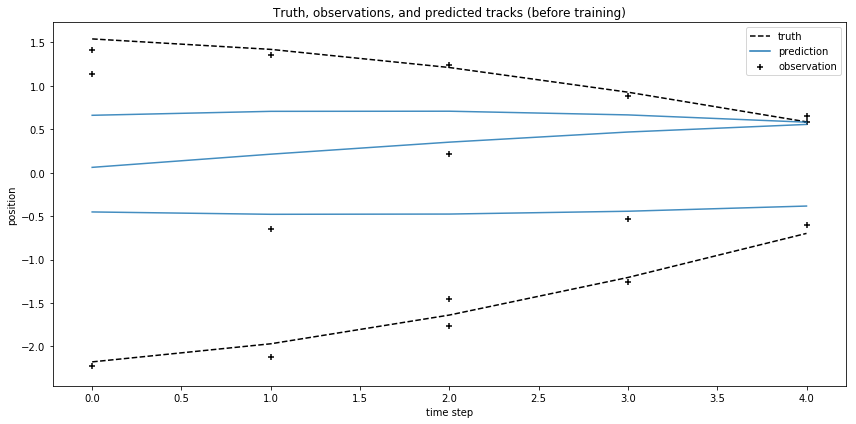

In [9]:
pyro.set_rng_seed(1)
pyro.clear_param_store()
plot_solution('(before training)')

In [10]:


infer = SVI(model, guide, Adam({"lr": 0.1}), TraceEnum_ELBO(max_iarange_nesting=2))
losses = []
for epoch in range(101 if not smoke_test else 2):
    loss = infer.step(args, observations)
    if epoch % 10 == 0:
        print("epoch {: >4d} loss = {}".format(epoch, loss))
    losses.append(loss)

epoch    0 loss = 527.65020752
epoch   10 loss = 525.061828613
epoch   20 loss = 486.578918457
epoch   30 loss = 480.597839355
epoch   40 loss = 484.498748779
epoch   50 loss = 487.460906982
epoch   60 loss = 480.590881348
epoch   70 loss = 484.059997559
epoch   80 loss = 478.725402832
epoch   90 loss = 482.139923096
epoch  100 loss = 482.640930176


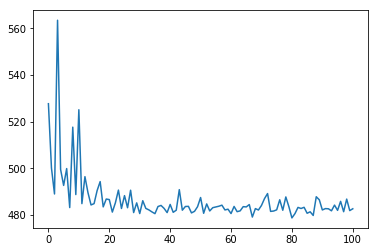

In [11]:
pyplot.plot(losses);

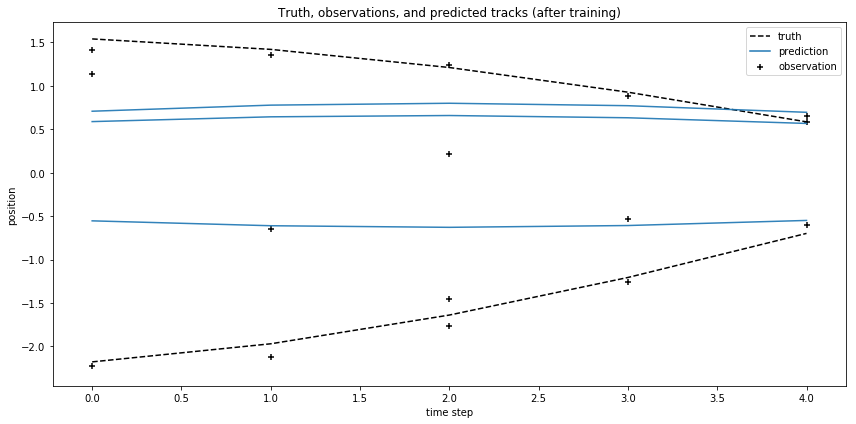

In [12]:
plot_solution('(after training)')